# First Exploratory Data Analysis of Crypto Data

## Plotting
* Plot data  in diffs
* Plot Correlations in diffs
* ACFs and CCFss in diffs
* Summary Statistics

## Goal: All things needed for a pre-causal analysis

In [4]:
import glob
import itertools
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyarrow.parquet as pq
import seaborn as sns
from statsmodels.tsa.stattools import acf, ccf, pacf
import scipy.stats as stats
import plotly.express as px
import plotly.graph_objects as go
import logging

# Import custom functions
# add parent directory to path
import sys
sys.path.append("..")
import src

# Set style for better visualizations
sns.set_theme()
sns.set_palette("husl")
plt.rcParams["figure.figsize"] = [12, 6]

### Functions

In [20]:
def load_parquet_data(data_dir: str = None, interval: str = "1m", logger=None) -> pd.DataFrame:
    """Initialize analyzer with data directory path."""

    if logger is None:
        # Set up logging with more detailed format
        logging.basicConfig(
            level=logging.INFO,
            format='%(asctime)s - %(levelname)s - %(message)s',
            datefmt='%Y-%m-%d %H:%M:%S'
        )
        logger = logging.getLogger(__name__)

    if data_dir is None:
        # Get the path relative to the script location
        script_dir = os.path.dirname(os.path.abspath(__file__))
        data_dir = os.path.join(script_dir, "data", "processed")
    else:
        data_dir = data_dir

    logger.info(f"Initializing analyzer with data directory: {data_dir}")

    logger.info("Starting data loading process...")

    all_data = {}
    all_returns = {}

    # Get absolute path for better debugging
    abs_data_dir = os.path.abspath(data_dir)
    logger.info(f"Looking for parquet files in: {abs_data_dir}")

    # Check if directory exists
    if not os.path.exists(abs_data_dir):
        logger.error(f"Directory does not exist: {abs_data_dir}")
        return pd.DataFrame()

    parquet_files = glob.glob(os.path.join(abs_data_dir, "*.parquet"))
    logger.info(f"Found {len(parquet_files)} parquet files")
    if len(parquet_files) == 0:
        logger.info("Contents of directory:")
        for item in os.listdir(abs_data_dir):
            logger.info(f"  {item}")

    for file in parquet_files:
        symbol = os.path.basename(file).split("_")[0]
        time = os.path.basename(file).split("_")[1]
        logger.info(f"Processing file for {symbol}")

        if time == interval:
            try:
                df = pq.read_table(file).to_pandas()
                logger.info(f"Loaded {len(df)} rows for {symbol}")

                if "simple_returns" not in df.columns:
                    # Calculate simple returns
                    logger.info(f"Calculating simple returns for {symbol}")
                    df["simple_returns"] = df["close"].pct_change()

                if "price_diff" not in df.columns:
                    # Calculate absolute difference
                    logger.info(f"Calculating price difference for {symbol}")
                    df["price_diff"] = df["close"].diff()

                if "log_returns" not in df.columns:
                    logger.info(f"Calculating log returns for {symbol}")
                    df["log_returns"] = np.log(df["close"]).diff()  # find log returns

                all_data[symbol] = df.dropna()
                all_returns[symbol] = df[
                    ["timestamp", "log_returns", "simple_returns", "price_diff"]
                ].copy().dropna()

                logger.info(f"Successfully processed {symbol}")

            except Exception as e:
                logger.error(f"Error processing {symbol}: {str(e)}")
                continue

    if not all_returns:
        logger.error("No data was loaded!")
        return pd.DataFrame()
    
    return all_returns, all_data

In [6]:
def plot_time_series_data(data, column="close", title=None, symbol=None):
    if symbol != None: 
        fig = px.line(data[f'{symbol}USDT'], x="timestamp", y=column, title=title)  
    
    else: 
        
    fig.show()

In [7]:
def load_and_prepare_data(data_dir="../data/processed/"):
    # Load raw data
    all_data = {}
    returns_data = {}

    for file in glob.glob(os.path.join(data_dir, "*.parquet")):
        symbol = os.path.basename(file).split("_")[0]
        df = pq.read_table(file).to_pandas()

        # Calculate log returns
        df["log_returns"] = np.log(df["close"]/df["close"].shift(1))

        # Calculate simple returns
        df["simple_returns"] = df["close"].pct_change()

        # Calculate absolute difference
        df["price_diff"] = df["close"].diff()

        all_data[symbol] = df
        returns_data[symbol] = df[
            ["timestamp", "log_returns", "simple_returns", "price_diff"]
        ].copy()

    return all_data, returns_data

In [8]:
def plot_acf_analysis(returns_data, diff_type="log_returns", max_lags=50):
    """
    Plot ACF for each cryptocurrency's returns/differences
    diff_type: 'log_returns', 'simple_returns', or 'price_diff'
    """
    for symbol, df in returns_data.items():
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))
        fig.suptitle(f"ACF Analysis of {diff_type} for {symbol}")

        series = df[diff_type].dropna()

        # ACF
        acf_values = acf(series, nlags=max_lags)
        ax1.stem(range(len(acf_values)), acf_values)
        ax1.axhline(y=0, linestyle="-", color="black")
        ax1.axhline(y=1.96 / np.sqrt(len(series)), linestyle="--", color="gray")
        ax1.axhline(y=-1.96 / np.sqrt(len(series)), linestyle="--", color="gray")
        ax1.set_title(f"Autocorrelation Function")

        # PACF
        pacf_values = pacf(series, nlags=max_lags)
        ax2.stem(range(len(pacf_values)), pacf_values)
        ax2.axhline(y=0, linestyle="-", color="black")
        ax2.axhline(y=1.96 / np.sqrt(len(series)), linestyle="--", color="gray")
        ax2.axhline(y=-1.96 / np.sqrt(len(series)), linestyle="--", color="gray")
        ax2.set_title(f"Partial Autocorrelation Function")

        plt.tight_layout()
        plt.show()

In [9]:
def plot_ccf_analysis(returns_data, diff_type="log_returns", max_lags=50):
    """
    Plot CCF between pairs of cryptocurrencies
    diff_type: 'log_returns', 'simple_returns', or 'price_diff'
    """
    # Get all pairs of cryptocurrencies
    pairs = list(itertools.combinations(returns_data.keys(), 2))

    for symbol1, symbol2 in pairs:
        # Get the return series
        series1 = returns_data[symbol1][diff_type].dropna()
        series2 = returns_data[symbol2][diff_type].dropna()

        # Calculate CCF
        ccf_values_ylag = ccf(series1, series2, adjusted=False)
        ccf_values_xlag = ccf(series2, series1, adjusted=False)
        ccf_values = np.concatenate([ccf_values_ylag[max_lags:0:-1],ccf_values_xlag[0:max_lags+1]])

        # Plot
        plt.figure(figsize=(15, 5))
        plt.stem(
            range(-max_lags, max_lags + 1),
            ccf_values  # +ve lag is when series1 leads series2 (y can be predicted by x)
        )
        plt.axhline(y=0, linestyle="-", color="black")
        plt.axhline(y=1.96 / np.sqrt(len(series1)), linestyle="--", color="gray")
        plt.axhline(y=-1.96 / np.sqrt(len(series1)), linestyle="--", color="gray")

        plt.title(f"Cross-Correlation of {diff_type}: {symbol1} vs {symbol2} (+ve lag: {symbol1} leads indicator for {symbol2})")
        plt.xlabel("Lag")
        plt.ylabel("CCF")

        # Find significant lags
        threshold = 1.96 / np.sqrt(len(series1))
        sig_lags = np.where(np.abs(ccf_values) > threshold)[0] - max_lags
        if len(sig_lags) > 0:
            print(f"\nSignificant lags between {symbol1} and {symbol2}:")
            for lag in sig_lags:
                corr = ccf_values[lag + max_lags]
                if lag < 0:
                    print(
                        f"{symbol2} leads {symbol1} by {abs(lag)} periods "
                        f"(correlation: {corr:.3f})"
                    )
                elif lag > 0:
                    print(
                        f"{symbol1} leads {symbol2} by {lag} periods "
                        f"(correlation: {corr:.3f})"
                    )

        plt.tight_layout()
        plt.show()

In [10]:
def create_lead_lag_summary(returns_data, diff_type='log_returns', lags=50):
    summary_data = []

    # Get all pairs of cryptocurrencies
    pairs = list(itertools.combinations(returns_data.keys(), 2))

    for symbol1, symbol2 in pairs:
        # Get the return series
        series1 = returns_data[symbol1][diff_type].dropna()
        series2 = returns_data[symbol2][diff_type].dropna()

        # Calculate CCF
        ccf_values_ylag = ccf(series1, series2, adjusted=False)
        ccf_values_xlag = ccf(series2, series1, adjusted=False)
        ccf_values = np.concatenate([ccf_values_ylag[lags:0:-1],ccf_values_xlag[1:lags+1]])

        # Find max correlation and corresponding lag and excluding coincident values
        max_corr_idx = np.argmax(np.abs(ccf_values))
        max_corr = ccf_values[max_corr_idx]
        max_lag = max_corr_idx - lags

        if max_lag < 0:
            leader = symbol2
            lagger = symbol1
            lag = abs(max_lag)
        else:
            # correct removed coincident values idx
            max_lag += 1
            leader = symbol1
            lagger = symbol2
            lag = max_lag

        summary_data.append({
            'Leader': leader,
            'Lagger': lagger,
            'Lag (minutes)': lag,
            'Correlation': max_corr
        })

    summary_df = pd.DataFrame(summary_data)
    # remove coincident values
    summary_df = summary_df[summary_df['Lag (minutes)'] != 0]

    return summary_df.sort_values('Correlation', key=abs, ascending=False)
    

In [11]:
def plot_returns_distribution(returns_data, diff_type="log_returns"):
    plt.figure(figsize=(15, 5))

    for symbol, df in returns_data.items():
        sns.kdeplot(data=df[diff_type].dropna(), label=symbol)

    plt.title(f"Distribution of {diff_type}")
    plt.xlabel("Return")
    plt.ylabel("Density")
    plt.legend()
    plt.show()


In [12]:
def plot_qq_normal(returns_data, diff_type="log_returns"):
    """Create QQ plots comparing each cryptocurrency's returns to normal distribution."""

    n_symbols = len(returns_data)
    n_cols = 2
    n_rows = (n_symbols + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
    fig.suptitle("QQ Plots vs Normal Distribution", fontsize=16, y=1.02)

    # Flatten axes for easier iteration
    if n_rows > 1:
        axes_flat = axes.flatten()
    else:
        axes_flat = [axes] if n_cols == 1 else axes

    for (symbol, returns), ax in zip(returns_data.items(), axes_flat):

        # Get the return series
        returns = returns[diff_type].dropna()

        # Standardize returns
        standardized_returns = (returns - returns.mean()) / returns.std()

        # Create QQ plot
        stats.probplot(standardized_returns.values, dist="norm", plot=ax)
        ax.set_title(f"{symbol} Returns vs Normal Distribution")

        # Calculate and display Shapiro-Wilk test
        stat, p_value = stats.shapiro(standardized_returns)
        ax.text(
            0.05,
            0.95,
            f"Shapiro-Wilk p-value: {p_value:.2e}",
            transform=ax.transAxes,
            fontsize=10,
            verticalalignment="top",
        )

    # Remove empty subplots if any
    for idx in range(len(returns_data), len(axes_flat)):
        fig.delaxes(ax[idx])

    plt.tight_layout()
    plt.show()

    

In [13]:
def plot_qq_pairs(returns_data, diff_type="log_returns"):
    """Create QQ plots comparing returns distributions between pairs of cryptocurrencies."""
    pairs = list(itertools.combinations(returns_data.keys(), 2))
    n_pairs = len(pairs)
    n_cols = 2
    n_rows = (n_pairs + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
    fig.suptitle("QQ Plots Between Cryptocurrency Pairs", fontsize=16, y=1.02)

    # Flatten axes for easier iteration
    axes_flat = axes.flatten() if isinstance(axes, np.ndarray) else [axes]

    for (symbol1, symbol2), ax in zip(pairs, axes_flat):
        returns1 = returns_data[symbol1][diff_type].dropna()
        returns2 = returns_data[symbol2][diff_type].dropna()

        # Standardize both return series
        std_returns1 = (returns1 - returns1.mean()) / returns1.std()
        std_returns2 = (returns2 - returns2.mean()) / returns2.std()

        # Get common length
        min_len = min(len(std_returns1), len(std_returns2))
        std_returns1 = std_returns1[:min_len]
        std_returns2 = std_returns2[:min_len]

        # Sort both series
        sorted1 = np.sort(std_returns1)
        sorted2 = np.sort(std_returns2)

        # Create QQ plot
        ax.scatter(sorted1, sorted2, alpha=0.5)

        # Add diagonal line
        min_val = min(sorted1.min(), sorted2.min())
        max_val = max(sorted1.max(), sorted2.max())
        ax.plot([min_val, max_val], [min_val, max_val], "r--")

        ax.set_title(f"QQ Plot: {symbol1} vs {symbol2}")
        ax.set_xlabel(f"{symbol1} Standardized Returns")
        ax.set_ylabel(f"{symbol2} Standardized Returns")

        # Calculate and display Kolmogorov-Smirnov test
        ks_stat, p_value = stats.ks_2samp(std_returns1, std_returns2)
        ax.text(
            0.05,
            0.95,
            f"KS test p-value: {p_value:.2e}",
            transform=ax.transAxes,
            fontsize=10,
            verticalalignment="top",
        )

    # Remove empty subplots if any
    for idx in range(len(pairs), len(axes_flat)):
        fig.delaxes(axes_flat[idx])

    plt.tight_layout()
    plt.show()
    

In [14]:
def print_distribution_stats(returns_data, diff_type="log_returns"):
    """Print summary statistics about the distribution of returns."""
    stats_df = pd.DataFrame(
        columns=["Mean", "Std", "Skewness", "Kurtosis", "Shapiro-Wilk p-value"]
    )

    for symbol, df in returns_data.items():
        # Get the return series
        reuturns = df[diff_type].dropna()

        # Standardize returns
        std_returns = (reuturns - reuturns.mean()) / reuturns.std()

        # Calculate statistic
        sw_stat, sw_p = stats.shapiro(std_returns)

        stats_df.loc[symbol] = [
            reuturns.mean(),
            reuturns.std(),
            stats.skew(reuturns),
            stats.kurtosis(reuturns),  # Fisher kurtosis (normal = 0)
            sw_p,
        ]

    print("\nDistribution Statistics:")
    print(stats_df)



### Plot timeseries data

In [25]:
# Load data
returns_data, all_data,  = load_parquet_data(data_dir="../data/processed/")


2024-12-20 11:15:44 - INFO - Initializing analyzer with data directory: ../data/processed/
2024-12-20 11:15:44 - INFO - Starting data loading process...
2024-12-20 11:15:44 - INFO - Looking for parquet files in: c:\Users\owooding\Documents\GradLearning\NickCryptoProject\CryptoCausality\data\processed
2024-12-20 11:15:44 - INFO - Found 6 parquet files
2024-12-20 11:15:44 - INFO - Processing file for ADAUSDT
2024-12-20 11:15:44 - INFO - Loaded 14401 rows for ADAUSDT
2024-12-20 11:15:44 - INFO - Calculating simple returns for ADAUSDT
2024-12-20 11:15:44 - INFO - Calculating price difference for ADAUSDT
2024-12-20 11:15:44 - INFO - Calculating log returns for ADAUSDT
2024-12-20 11:15:44 - INFO - Successfully processed ADAUSDT
2024-12-20 11:15:44 - INFO - Processing file for BNBUSDT
2024-12-20 11:15:44 - INFO - Loaded 14401 rows for BNBUSDT
2024-12-20 11:15:44 - INFO - Calculating simple returns for BNBUSDT
2024-12-20 11:15:44 - INFO - Calculating price difference for BNBUSDT
2024-12-20 11:

In [28]:
# plot all results
for coin in all_data.keys(): 
    plot_time_series_data(all_data, title=f"{coin} Close Price", combine=True)

In [122]:
# Summary Statistics
summary_stats = pd.DataFrame()
for symbol, returns in returns_data.items():
    stats_df = returns['log_returns'].describe()
    stats_df['skewness'] = returns['log_returns'].skew()
    stats_df['kurtosis'] = returns['log_returns'].kurtosis()
    summary_stats[symbol] = stats_df

print("\nSummary Statistics for Returns:")
print(summary_stats)



Summary Statistics for Returns:
               ADAUSDT       BNBUSDT       BTCUSDT      DOGEUSDT  \
count     44640.000000  4.464000e+04  4.464000e+04  44640.000000   
mean         -0.000004 -8.261214e-07  1.763238e-07     -0.000003   
std           0.001276  9.118501e-04  8.059727e-04      0.001179   
min          -0.049435 -2.952364e-02 -2.735821e-02     -0.054418   
25%          -0.000602 -3.303055e-04 -3.163289e-04     -0.000482   
50%           0.000000  0.000000e+00  0.000000e+00      0.000000   
75%           0.000593  3.300875e-04  3.231704e-04      0.000478   
max           0.025432  3.608718e-02  1.501286e-02      0.054653   
skewness     -3.229180  2.590119e-01 -3.173194e+00     -2.799927   
kurtosis    132.429948  1.204319e+02  1.238676e+02    383.833120   

               ETHUSDT       XRPUSDT  
count     4.464000e+04  44640.000000  
mean      4.246179e-08     -0.000004  
std       8.247499e-04      0.001082  
min      -2.973708e-02     -0.083560  
25%      -3.554860e-04 

## Cross-Correlation Analysis

In [2]:
# Create a combined returns dataframe
combined_returns = pd.DataFrame()
for symbol, returns in returns_data.items():
    combined_returns[symbol] = returns['log_returns']
combined_returns.index = list(returns_data.values())[0]['timestamp']

# plot correlation heatmap
corr = combined_returns.corr()
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap of Cryptocurrencies")
plt.show()


NameError: name 'pd' is not defined

In [3]:
# Load data
all_data, returns_data = load_and_prepare_data()

# Plot ACF analysis for log returns
print("ACF Analysis of Log Returns")
plot_acf_analysis(returns_data, diff_type="log_returns")

# Plot CCF analysis for log returns
print("\nCCF Analysis of Log Returns")
plot_ccf_analysis(returns_data, diff_type="log_returns")


NameError: name 'load_and_prepare_data' is not defined

In [102]:
# Show summary of lead-lag relationships
summary_df = create_lead_lag_summary(returns_data)
print("Summary of Strongest Lead-Lag Relationships:")
print(summary_df)


Summary of Strongest Lead-Lag Relationships:
      Leader    Lagger  Lag (minutes)  Correlation
4    ADAUSDT   XRPUSDT              1     0.129604
13  DOGEUSDT   XRPUSDT              1     0.120259
14   ETHUSDT   XRPUSDT              1     0.101110
8    BNBUSDT   XRPUSDT              1     0.100618
11   BTCUSDT   XRPUSDT              1     0.096644
9    BTCUSDT  DOGEUSDT              1     0.058017
12  DOGEUSDT   ETHUSDT              2    -0.053214
2    ADAUSDT  DOGEUSDT              1     0.052535
1    ADAUSDT   BTCUSDT              2    -0.051754
6    BNBUSDT  DOGEUSDT              1     0.050441
10   ETHUSDT   BTCUSDT              2    -0.048976
0    BNBUSDT   ADAUSDT              1     0.045379
3    ADAUSDT   ETHUSDT              2    -0.038502
5    BNBUSDT   BTCUSDT              2    -0.033925
7    ETHUSDT   BNBUSDT             13    -0.028151


### Vol Analysis

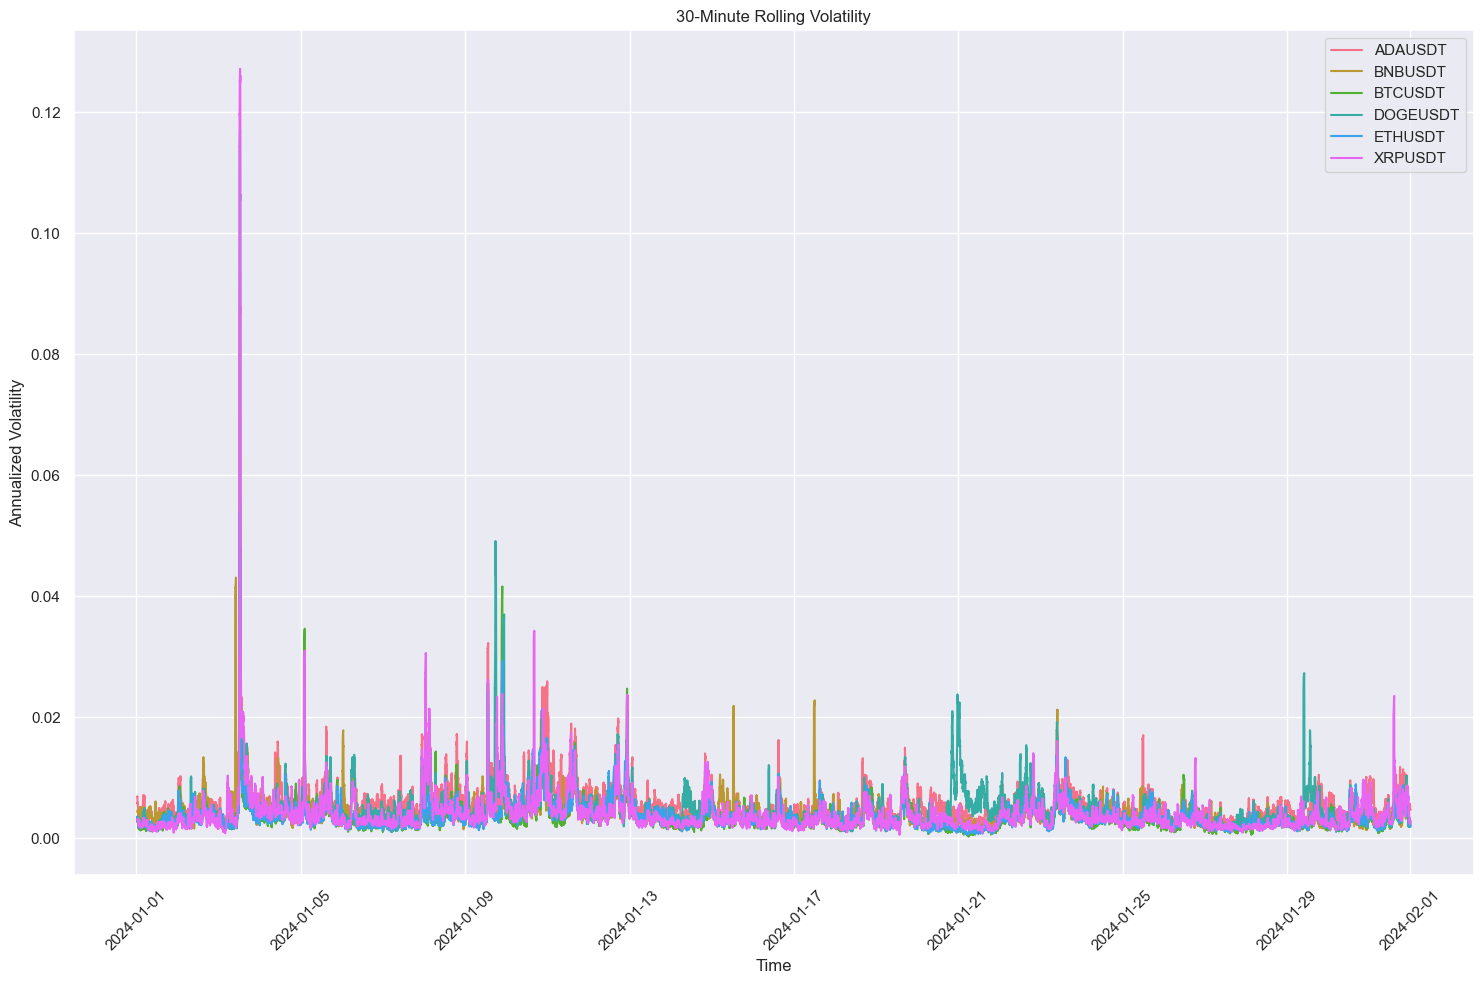

In [103]:
# Volatility Analysis
# Calculate rolling volatility (30-minute window)
plt.figure(figsize=(15, 10))
for symbol, returns in returns_data.items():
    vol = returns['log_returns'].rolling(window=30).std() * np.sqrt(30)
    plt.plot(returns['timestamp'], vol, label=symbol)

plt.title('30-Minute Rolling Volatility')
plt.xlabel('Time')
plt.ylabel('Annualized Volatility')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### Returns Distribution

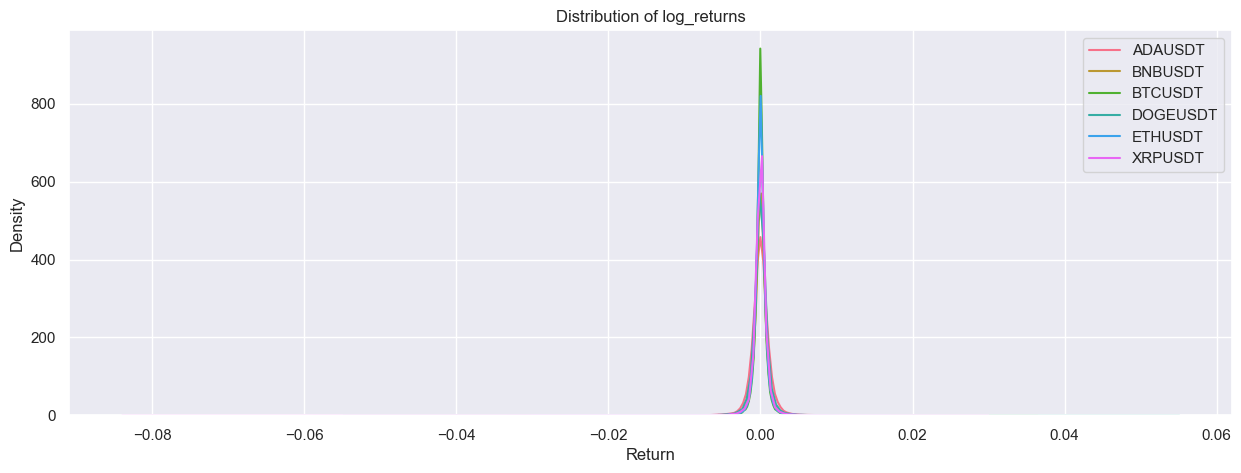

In [104]:
plot_returns_distribution(returns_data, "log_returns")

QQ Plots vs Normal Distribution


c:\Users\owooding\.conda\envs\env\lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning:

scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 44640.



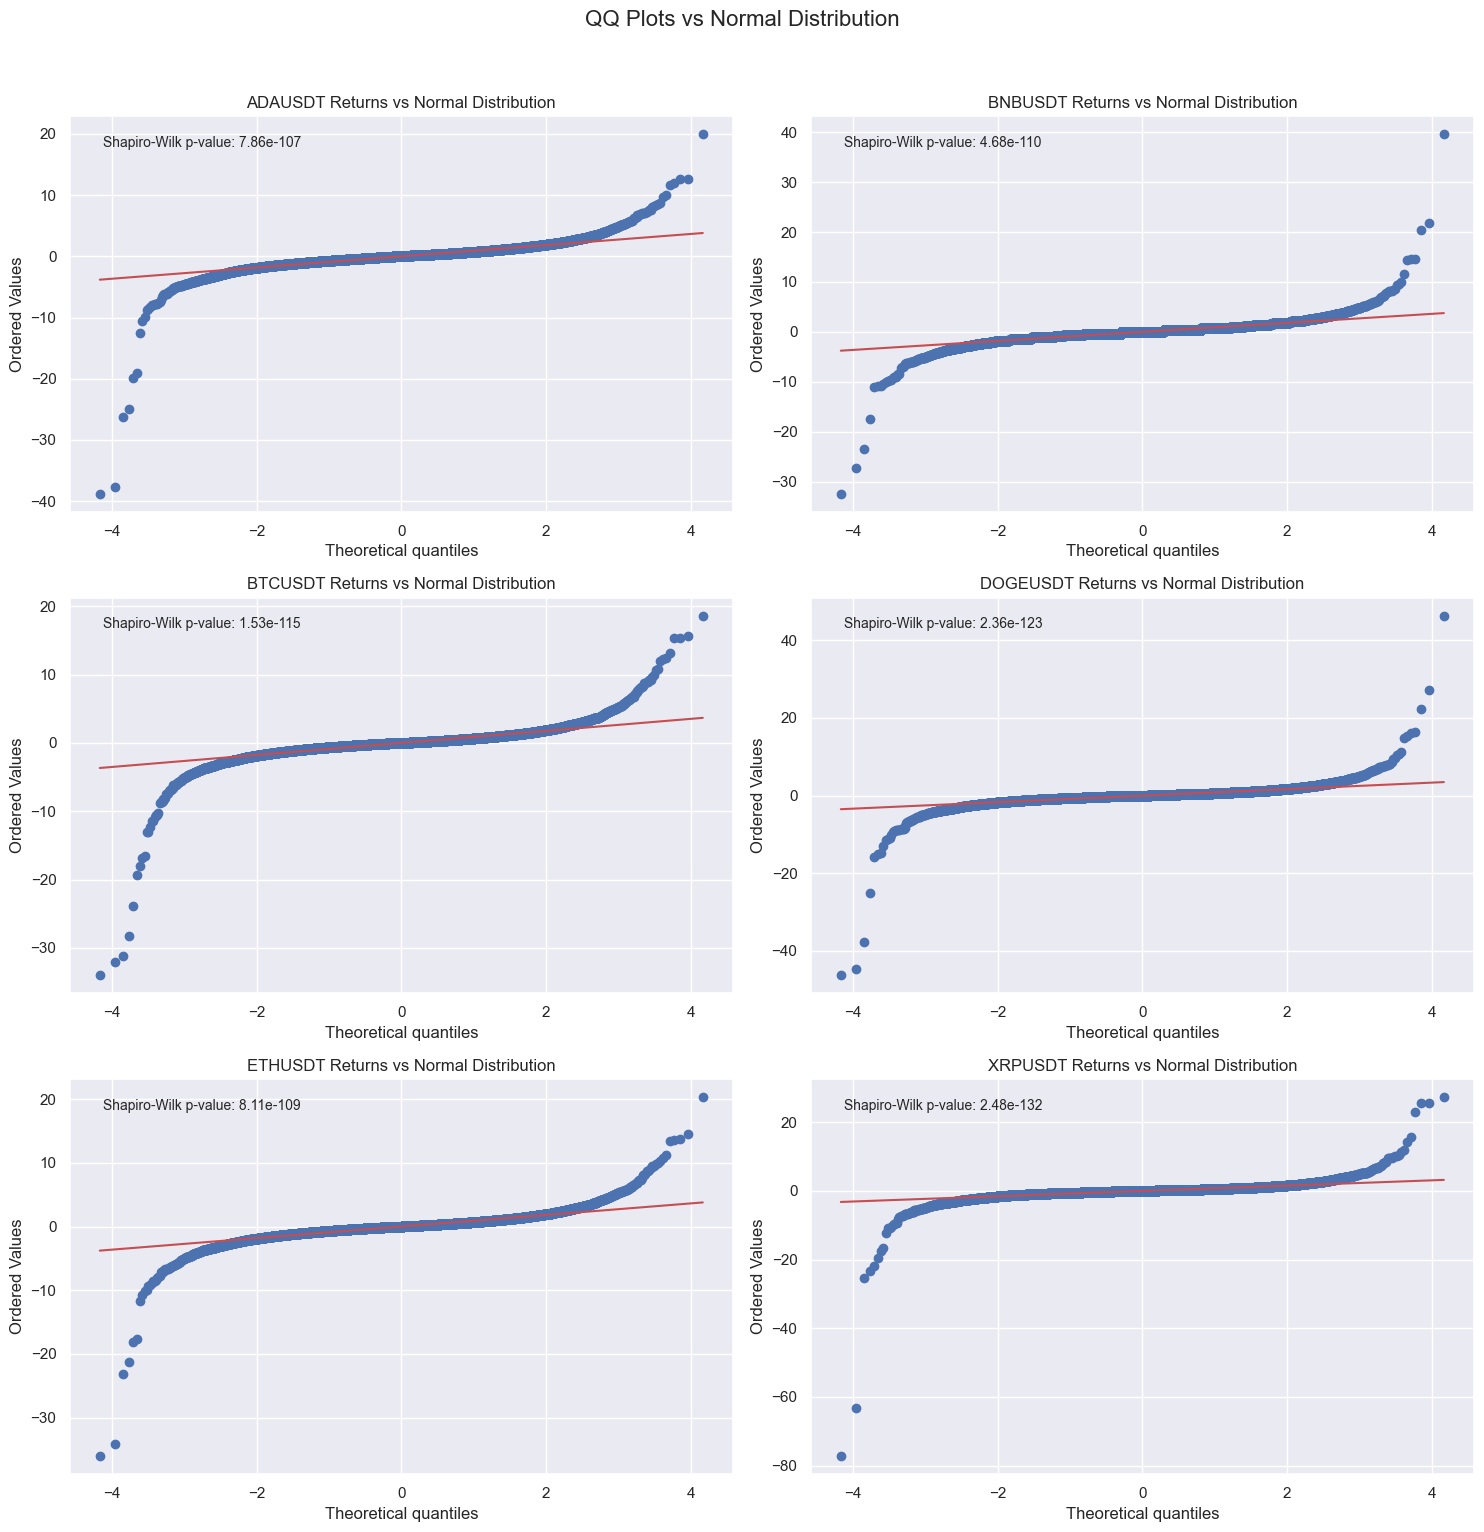


QQ Plots Between Cryptocurrency Pairs


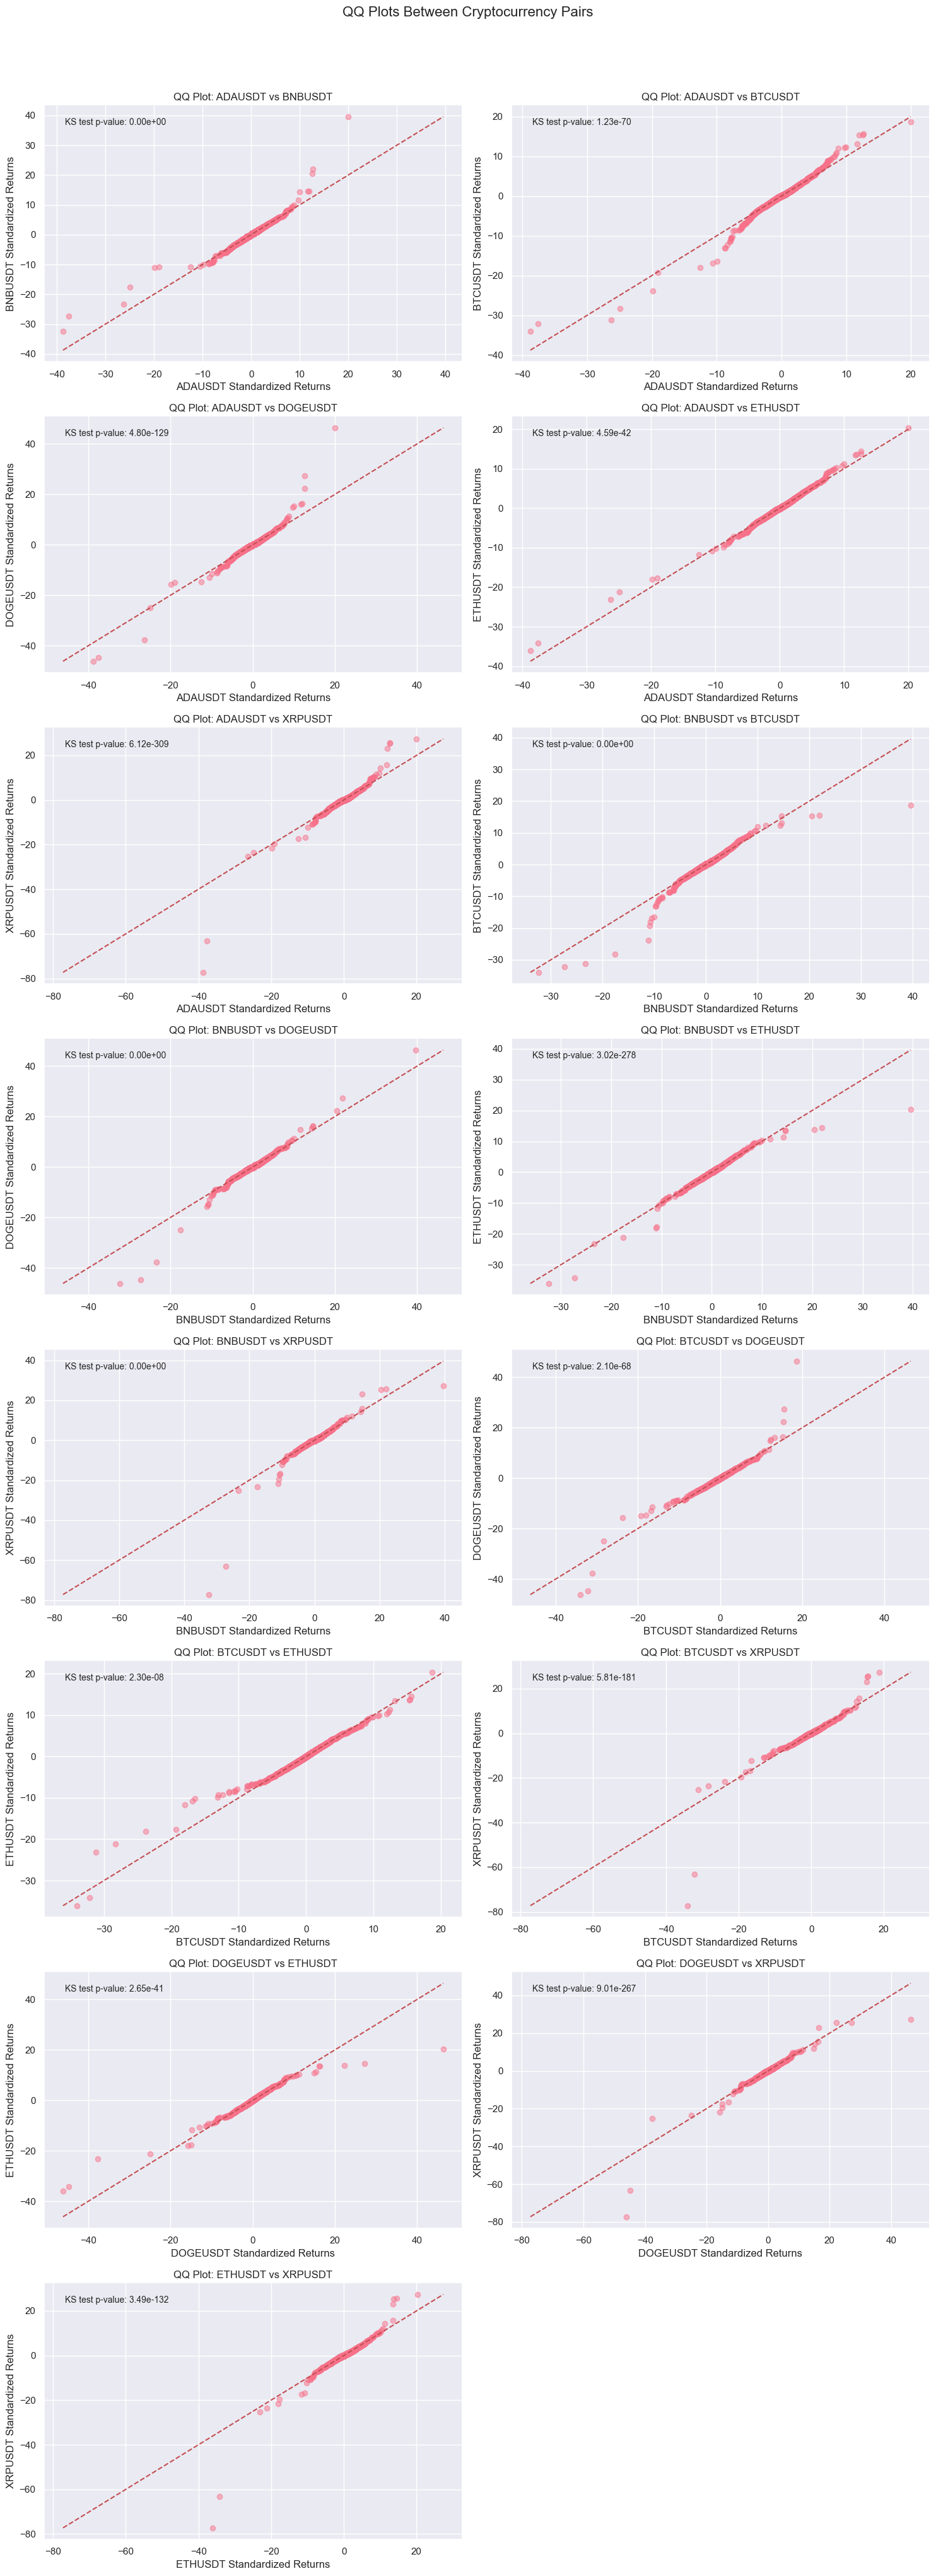

In [105]:
# Plot QQ plots vs normal distribution
print("QQ Plots vs Normal Distribution")
plot_qq_normal(returns_data)

# Plot QQ plots between pairs
print("\nQQ Plots Between Cryptocurrency Pairs")
plot_qq_pairs(returns_data)


In [53]:
def main():
    """Main visualization pipeline."""
    # Example usage
    from src.data.processor import DataProcessor
    import pyarrow.parquet as pq
    import os
    from src.config import PROCESSED_DATA_PATH

    # Load data
    logger.info("Loading data...")

    all_data = {}
    for file in os.listdir(PROCESSED_DATA_PATH):
        if file.endswith('.parquet'):
            symbol = file.split('_')[0]
            file_path = os.path.join(PROCESSED_DATA_PATH, file)
            df = pq.read_table(file_path).to_pandas()
            all_data[symbol] = df['log_returns']

    data = pd.DataFrame(all_data)

    # Run causality analysis
    analyzer = CausalityAnalyzer(data)
    results = {
        'granger': analyzer.analyze_all_causality()['granger'],
        'causality_network': analyzer.create_causality_network()
    }

    # Create visualizations
    visualizer = ResultsVisualizer(data, results)
    visualizer.plot_all_results()

if __name__ == "__main__":
    main()

NameError: name 'standardized_returns' is not defined

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from src.visualization.causality_viz import CausalityVisualizer
from src.analysis.causality import CausalityAnalyzer
from src.utils.helpers import calculate_returns
import os
import logging
from typing import Dict, Optional
import networkx as nx
from scipy import stats

# Set up logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

def main():
    # Load data
    returns_df = load_and_prepare_data()
    
    # Run Granger causality analysis
    analyzer = GrangerCausalityAnalyzer(
        data=returns_df,
        max_lags=10,
        test_type='ssr_chi2test'
    )
    
    causality_results = analyzer.run_pairwise_causality()
    summary_stats = analyzer.get_summary_statistics()
    
    # Create visualizations
    visualizer = CausalityVisualizer(significance_level=0.05)
    
    # 1. Heatmap of p-values
    print("Plotting causality heatmap...")
    visualizer.plot_causality_heatmap(
        causality_results,
        title='Granger Causality P-values Between Cryptocurrencies'
    )
    
    # 2. Network diagram
    print("Plotting causality network...")
    visualizer.plot_causality_network(
        causality_results,
        layout='spring',
        title='Cryptocurrency Causality Network'
    )
    
    # 3. Summary bar plots
    print("Plotting summary statistics...")
    visualizer.plot_summary_bars(
        summary_stats,
        title='Causality Influence Summary'
    )
    
    # 4. Lag distribution
    print("Plotting lag distribution...")
    visualizer.plot_lag_distribution(
        causality_results,
        title='Distribution of Optimal Lag Orders'
    )
